In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

from bench_isolation_forest_parallel_predict import ParallelPredIsolationForest, get_data

%load_ext memory_profiler

Benchmark ran on a MacBook Pro with the following specs:

- MacBook Pro (15-inch, 2018)
- Processor: 2,9 GHz Intel Core i9
- Memory: 32 GB 2400 MHz DDR4

# Benchmark

In this notebook, we are studying the impact in memory consumption of running the *predict* method of Isolation Forest, in comparison with the current single-threaded one.

**Methodology**
- We use memory profile to check how much the call to predict method increases the amount of used memory.
- We define a random matrix of 500k samples and 50 features, both for training and test.
- First, we measure how much the current single threaded method increases the memory consumption.
- Then, we vary the number of parallel jobs in the PR IForest from 1 until 12.
- We compute the increment in memory usage as $\frac{m_n}{m_s}$, where $m_n$ represents the memory usage when using $n \in \{1, \cdots, 12\}$ parallel jobs, and $m_s$ is the memory usage of the single threaded approach.

In [2]:
n_samples = 500000
X_train, X_test = get_data(n_samples_train=n_samples, n_samples_test=n_samples, 
                           n_features=50, contamination=0.1, seed=19900603)

Current, single threaded approach.

In [3]:
# Current single threaded
iforest = IsolationForest(n_estimators=100, n_jobs=12, random_state=123)
iforest.fit(X_train)
%memit _ = iforest.predict(X_test)

peak memory: 1762.66 MiB, increment: 803.93 MiB


Next, we evaluate the impact of the number of parallel jobs in the current PR.

In [4]:
%%time

for n_jobs in np.arange(1, 13):
    print('Number of jobs: {}'.format(n_jobs))
    iforest = ParallelPredIsolationForest(n_estimators=100, n_jobs=n_jobs, random_state=123)
    iforest.fit(X_train)
    %memit _ = iforest.predict(X_test)

Number of jobs: 1
peak memory: 1672.75 MiB, increment: 561.77 MiB
Number of jobs: 2
peak memory: 1951.14 MiB, increment: 871.23 MiB
Number of jobs: 3
peak memory: 2427.90 MiB, increment: 1382.48 MiB
Number of jobs: 4
peak memory: 2894.32 MiB, increment: 1922.65 MiB
Number of jobs: 5
peak memory: 3303.13 MiB, increment: 2335.59 MiB
Number of jobs: 6
peak memory: 3591.34 MiB, increment: 2622.84 MiB
Number of jobs: 7
peak memory: 4135.90 MiB, increment: 3174.82 MiB
Number of jobs: 8
peak memory: 4540.88 MiB, increment: 3572.80 MiB
Number of jobs: 9
peak memory: 4926.68 MiB, increment: 3958.35 MiB
Number of jobs: 10
peak memory: 5436.60 MiB, increment: 4468.05 MiB
Number of jobs: 11
peak memory: 5935.91 MiB, increment: 4968.23 MiB
Number of jobs: 12
peak memory: 6388.95 MiB, increment: 5421.25 MiB
CPU times: user 36min 55s, sys: 16min 42s, total: 53min 37s
Wall time: 12min 2s


In [5]:
single_threaded = 803.93
jobs = np.arange(1, 13)
multi_threaded = [561.77, 871.23, 1382.48, 1922.65, 2335.59, 2622.84, 
                  3174.82, 3572.80, 3958.35, 4468.05, 4968.23, 5421.25]
memory_increase = [memory / single_threaded for memory in multi_threaded]

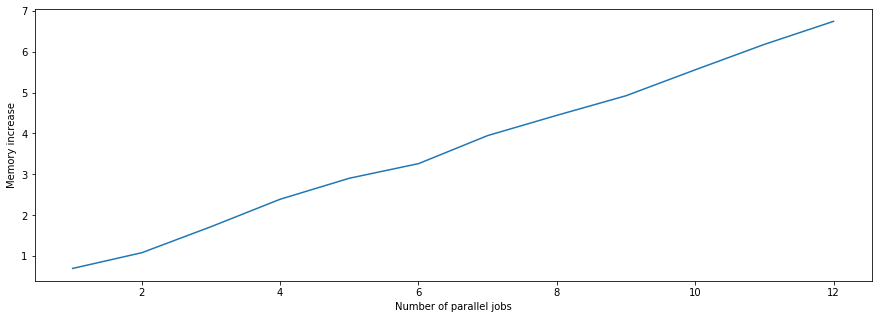

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(jobs, memory_increase)
plt.xlabel('Number of parallel jobs')
plt.ylabel('Memory increase')
plt.show()

### Final remarks 

From the plot above, we can conclude that running the *predict* function of Isolation Forest using parallel jobs comes with an increase in memory usage that is approximately linear with the number of parallel jobs.

However, we also note that for 12 jobs, the increase in memory usage is less than 7 times the increase in memory from calling the *predict* function in the single threaded mode. Therefore, the memory increase of the parallel prediction appears to be a little more than $\frac{1}{2}$ times the number of parallel jobs.